In [1]:
from binit.align import align_around
import numpy as np
from scipy.stats import zscore
from observational_fear import load
from neurobox.wide_transforms import resample
from observational_fear.events import get_block_starts
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
from matplotlib.ticker import MaxNLocator
sns.set_style("whitegrid")


def get_bloc_psth(df, events, t_before=5, t_after=5):
    df = df.reset_index().melt(id_vars=["time"])
    return (
        df
        .assign(
            aligned=lambda x: np.round(
                align_around(x["time"].values, events, t_before=t_before, max_latency=t_after), 2
            )
        )
        .pivot_table(columns="new_id", values="value", index="aligned")
        .apply(zscore)
    )

DATA_DIR = Path(r"F:\OFL\one-p experiment\data")
FIG_DIR = Path(r"C:\Users\roryl\repos\observational-fear\figs")


In [2]:
SESSION = "day2"
df_d2 = load.load_traces(DATA_DIR, session=SESSION)
df_d2 = resample(df_d2.set_index("time"), "100ms")
usd2events = get_block_starts(session="day2", block_name="US")

c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


In [51]:
usd2events = get_block_starts(session="day2", block_name="US")
Xbefore = get_bloc_psth(df_d2, usd2events, t_after=0.1)
Xafter = get_bloc_psth(df_d2, usd2events, t_before=0.1, t_after=5)

scree_before = (1- PCA().fit(Xbefore).explained_variance_ratio_) * 100
scree_after = (1- PCA().fit(Xafter).explained_variance_ratio_) * 100

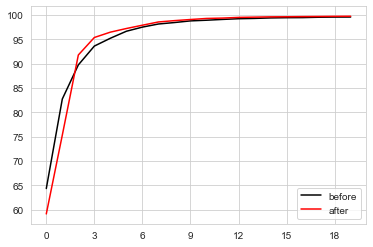

In [52]:
plt.plot(scree_before[:20], label="before", color="black")
plt.plot(scree_after[:20], label="after", color="red")
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [53]:
SESSION = "day4"
df_d4 = load.load_traces(DATA_DIR, session=SESSION)
df_d4 = resample(df_d4.set_index("time"), "100ms")

c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


In [54]:
usd4events = get_block_starts(session="day4", block_name="US")
Xbefore = get_bloc_psth(df_d4, usd2events, t_after=0.1)
Xafter = get_bloc_psth(df_d4, usd2events, t_before=0.1, t_after=5)

scree_before_d4 = (1- PCA().fit(Xbefore).explained_variance_ratio_) * 100
scree_after_d4 = (1- PCA().fit(Xafter).explained_variance_ratio_) * 100

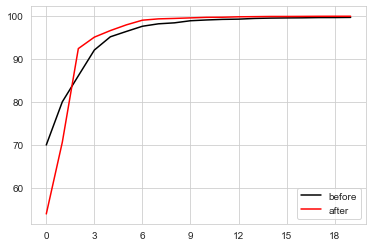

In [55]:
plt.plot(scree_before_d4[:20], label="before", color="black")
plt.plot(scree_after_d4[:20], label="after", color="red")
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

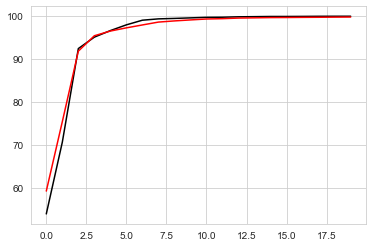

In [56]:
plt.plot(scree_after_d4[:20], label="Day4", color="black")
plt.plot(scree_after[:20], label="Day2", color="red")

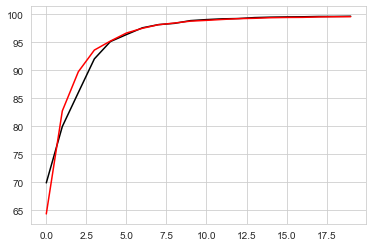

In [57]:
plt.plot(scree_before_d4[:20], label="Day4", color="black")
plt.plot(scree_before[:20], label="Day2", color="red")

In [60]:

cells = load.load_cells(DATA_DIR)

In [109]:
def get_scree(df_traces, events, t_after=5):
    Xbefore = get_bloc_psth(df_traces, events, t_after=0.1)
    Xafter = get_bloc_psth(df_traces, events, t_before=0.1, t_after=t_after)
    scree_before = (1- PCA().fit(Xbefore).explained_variance_ratio_) * 100
    scree_after = (1- PCA().fit(Xafter).explained_variance_ratio_) * 100
    return pd.DataFrame({"before": scree_before[:20], "after":scree_after[:20]}).reset_index()




usd2events = get_block_starts(session="day2", block_name="US")
usd4events = get_block_starts(session="day4", block_name="US")


res = []
for mouse in cells.mouse.unique():
    print(mouse)
    cell_ids = cells.loc[lambda x: x.mouse == mouse].new_id.unique().astype(str)
    df_d2_sub = df_d2[[c for c in df_d2.columns if c in cell_ids]]
    df_d4_sub = df_d4[[c for c in df_d4.columns if c in cell_ids]]
    res_day2 = get_scree(df_d2_sub, usd2events).assign(session="day2")
    res_day4 = get_scree(df_d4_sub, usd4events).assign(session="day4")
    res.append(pd.concat([res_day2, res_day4]).assign(mouse=mouse))

res = pd.concat(res)

B17274
B17276
B43396
PL-OFL-2
PL-OFL-4
PL-OFL-5
PL-OFL-6
PL-OFL-7


Text(0.5, 1.0, 'day2')

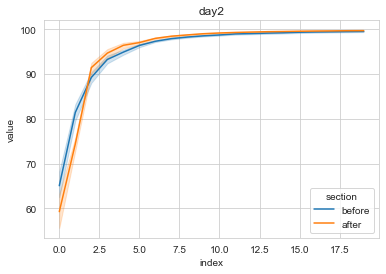

In [117]:
(
    res.loc[lambda x: x.session == "day2"]
    .melt(id_vars=["index", "mouse", "session"], var_name="section")
    .pipe((sns.lineplot, "data"), x="index", y="value", hue="section")
)
plt.title("day2")

Text(0.5, 1.0, 'day4')

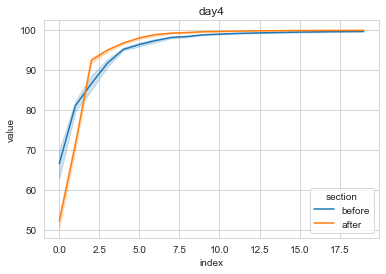

In [115]:
(
    res.loc[lambda x: x.session == "day4"]
    .melt(id_vars=["index", "mouse", "session"], var_name="section")
    .pipe((sns.lineplot, "data"), x="index", y="value", hue="section")
)
plt.title("day4")

Text(0.5, 1.0, 'Post Comparison')

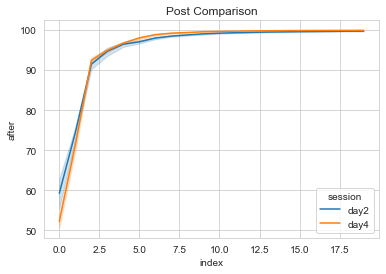

In [116]:
sns.lineplot(data=res.reset_index(drop=True), x="index", y="after", hue="session")

plt.title("Post Comparison")

In [113]:
from observational_fear.stats import auc
from scipy.stats import wilcoxon

(
    res
    .loc[lambda x: x.session == "day4"]
    .melt(id_vars=["index", "mouse", "session"], var_name="section")
    .groupby(["mouse","section", "session"], as_index=False)["value"]
    .apply(auc)
    .pivot(index="mouse", columns="section", values="value")
    .pipe(lambda x: wilcoxon(x["before"], x["after"]))
    # .pipe((sns.lineplot, "data"), x="index", y="value", hue="section")
)

WilcoxonResult(statistic=3.0, pvalue=0.0390625)

In [114]:
(
    res
    .loc[lambda x: x.session == "day2"]
    .melt(id_vars=["index", "mouse", "session"], var_name="section")
    .groupby(["mouse","section", "session"], as_index=False)["value"]
    .apply(auc)
    .pivot(index="mouse", columns="section", values="value")
    .pipe(lambda x: wilcoxon(x["before"], x["after"]))
    # .pipe((sns.lineplot, "data"), x="index", y="value", hue="section")
)

WilcoxonResult(statistic=13.0, pvalue=0.546875)

In [10]:
SESSION = "day2"
df = load.load_traces(DATA_DIR, session=SESSION)
df = resample(df.set_index("time"), "100ms").reset_index().melt(id_vars=["time"])
events = get_block_starts(session=SESSION, block_name="US")


c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


In [30]:
from binit.bin import which_bin_idx
from binit.align import align_around

time_before=5
time_after=5
df["trial_idx"] = which_bin_idx(df["time"].values, bin_edges=events, time_before=time_before, time_after=time_after)
df = df.dropna()
df["aligned"] = align_around(df["time"].values, events, t_before=time_before, max_latency=time_after)

C:\Users\roryl\.conda\envs\observational-fear\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
from scipy.stats import zscore
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def get_scree(df, time_col="aligned", neuron_col="new_id", value_col="value"):
    df = df.pivot(index=time_col, columns=neuron_col, values=value_col)
    Xbefore = df.loc[lambda x: x.index.values < 0].apply(zscore).dropna(axis=1)
    Xafter = df.loc[lambda x: x.index >= 0].apply(zscore).dropna(axis=1)
    scree_before = (1- PCA().fit(Xbefore).explained_variance_ratio_) * 100
    scree_after = (1- PCA().fit(Xafter).explained_variance_ratio_) * 100
    return pd.DataFrame({"before": scree_before[:20], "after":scree_after[:20]}).reset_index()
    
res = df.groupby("trial_idx").apply(get_scree)

index     before      after
trial_idx                                
0.0       0       0  71.569563  69.746758
          1       1  86.583460  82.784546
          2       2  90.426836  92.063245
          3       3  93.355239  94.004269
          4       4  95.306523  95.547761
...             ...        ...        ...
29.0      15     15  98.984149  99.144184
          16     16  99.045250  99.179797
          17     17  99.056229  99.205287
          18     18  99.096826  99.208225
          19     19  99.121891  99.224561

[600 rows x 3 columns]

In [ ]:
events = get_block_starts(session="day2", block_name="US")


df = df.reset_index().melt(id_vars=["time"])

In [ ]:
for mouse in cells.mouse.unique():
    print(mouse)
    cell_ids = cells.loc[lambda x: x.mouse == mouse].new_id.unique().astype(str)
    df_d2_sub = df_d2[[c for c in df_d2.columns if c in cell_ids]]
    res_day2 = get_scree(df_d2_sub, usd2events).assign(session="day2")
    
    
    # res_day4 = get_scree(df_d4_sub, usd4events).assign(session="day4")
    # df_d4_sub = df_d4[[c for c in df_d4.columns if c in cell_ids]]

    res.append(pd.concat([res_day2, res_day4]).assign(mouse=mouse))

In [ ]:
def get_scree(df_traces, events, t_after=5):
    Xbefore = get_bloc_psth(df_traces, events, t_after=0.1)
    Xafter = get_bloc_psth(df_traces, events, t_before=0.1, t_after=t_after)
    scree_before = (1- PCA().fit(Xbefore).explained_variance_ratio_) * 100
    scree_after = (1- PCA().fit(Xafter).explained_variance_ratio_) * 100
    return pd.DataFrame({"before": scree_before[:20], "after":scree_after[:20]}).reset_index()

In [3]:
def get_bloc_psth(df, events, t_before=5, t_after=5):
    df = df.reset_index().melt(id_vars=["time"])
    return (
        df
        .assign(
            aligned=lambda x: np.round(
                align_around(x["time"].values, events, t_before=t_before, max_latency=t_after), 2
            )
        )
        .pivot_table(columns="new_id", values="value", index="aligned")
        .apply(zscore)
    )

new_id,0,1,10,1000,1003,1004,1005,1006,1008,1009,...,974,977,979,984,986,988,989,994,997,999
time,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,17.02812,865.7206,2.397007,7.793715,3.091322,3.573143,6.365594,1.725642,9.803617,...,8.366630,3.442710,27.272230,-0.842751,10.710870,0.257933,-0.178971,6.109560,-1.523219,20.64678
0.1,0.0,16.05030,826.8458,2.386678,7.972757,4.140354,2.161628,7.239542,1.110307,10.247110,...,10.425380,0.051314,27.694580,1.502514,8.021098,0.111355,-0.114964,4.048251,-2.146909,18.80727
0.2,0.0,15.12864,789.7167,3.888895,7.748977,5.193838,1.286437,6.071523,2.171293,10.086010,...,9.642082,0.109932,28.125560,-1.868842,9.747852,1.114896,-0.749472,6.450645,-3.179096,18.67363
0.3,0.0,14.25989,754.2548,4.090078,8.323790,4.019863,2.055419,5.615175,3.702808,10.746050,...,11.239180,1.843151,23.785780,-1.863744,8.085772,1.739338,-2.783701,6.568225,-3.446709,14.98636
0.4,0.0,13.44104,720.3854,2.269290,8.518371,4.881327,2.296408,4.968860,1.904407,9.089672,...,10.126570,1.051976,22.908690,-0.014785,6.303493,2.129591,0.614705,4.606218,-3.946769,15.54969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159.5,NaN,NaN,NaN,1.943573,2.454499,40.466190,1.526922,-1.609898,1.908993,6.178200,...,4.400855,-0.697620,3.159167,-0.153303,8.410807,1.986327,2.128006,-4.560377,2.446120,16.66476
2159.6,NaN,NaN,NaN,1.507344,4.327056,39.835370,1.960606,-0.545312,1.685918,5.664702,...,6.184270,-0.057254,2.757570,2.306422,8.767282,1.420987,1.812016,-1.998636,1.681458,14.23011
2159.7,NaN,NaN,NaN,0.973684,2.111598,39.368900,-0.762297,-0.049391,3.630211,4.525940,...,5.566843,1.585912,2.459871,0.426155,9.760431,2.369032,1.494351,-1.866246,3.895738,14.82364


In [96]:
from scipy.stats import zscore
from binit.bin import which_bin_idx
from binit.align import align_around
from sklearn.decomposition import PCA


def get_scree(df, time_col="aligned", neuron_col="new_id", value_col="value"):
    df = df.pivot(index=time_col, columns=neuron_col, values=value_col).apply(zscore)
    Xbefore = df.loc[lambda x: x.index.values < 0].dropna(axis=1)
    Xafter = df.loc[lambda x: x.index >= 0].dropna(axis=1)
    scree_before = (1- PCA().fit(Xbefore).explained_variance_ratio_) * 100
    scree_after = (1- PCA().fit(Xafter).explained_variance_ratio_) * 100
    return pd.DataFrame({"before": scree_before[:20], "after":scree_after[:20]}).reset_index()

def get_scree_by_block(df, events, time_before=5, time_after=5, time_col="time", neuron_col="new_id", value_col="value"):
    df = df.copy()
    df["trial_idx"] = which_bin_idx(df[time_col].values, bin_edges=events, 
    time_before=time_before, time_after=time_after
    )
    df = df.dropna().copy()
    df["aligned"] = align_around(df[time_col].values, events, t_before=time_before, max_latency=time_after)
    return df.groupby("trial_idx").apply(get_scree, time_col="aligned", neuron_col=neuron_col, value_col=value_col).reset_index()

SESSION = "day2"
EVENT = "CS"
df = load.load_traces(DATA_DIR, session=SESSION)
df = resample(df.set_index("time"), "100ms").reset_index().melt(id_vars=["time"])
events = get_block_starts(session=SESSION, block_name=EVENT)
cells = load.load_cells(DATA_DIR)

res = []
for mouse in cells.mouse.unique():
    cell_ids = cells.loc[lambda x: x.mouse == mouse].new_id.unique().astype(str)
    df_sub = df.loc[lambda x: x.new_id.isin(cell_ids)]
    res_df = get_scree_by_block(df_sub, events, time_before=5, time_after=5).assign(session=SESSION, mouse=mouse)
    res.append(res_df)

c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


In [97]:
from observational_fear.stats import auc

def auc_prepost(df):
    out = {}
    out["before"] = auc(df["before"])
    out["after"] = auc(df["after"])
    return pd.Series(out)

df_by_trial = pd.concat(res).groupby(["trial_idx", "mouse"], as_index=False).apply(auc_prepost)

<AxesSubplot:xlabel='trial_idx', ylabel='divergence'>

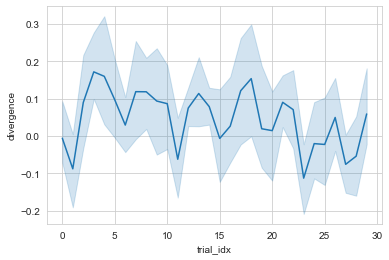

In [98]:
import seaborn as sns



sns.lineplot(data=df_by_trial.assign(divergence=lambda x: x.before - x.after), x="trial_idx", y="divergence")

<AxesSubplot:xlabel='trial_idx', ylabel='value'>

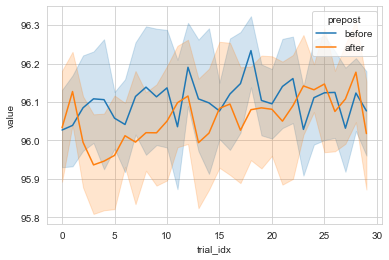

In [99]:
df_by_trial.melt(id_vars=["trial_idx", "mouse"], var_name="prepost").pipe((sns.lineplot, "data"), x="trial_idx", hue="prepost", y="value")

In [100]:
df_by_trial

,trial_idx,mouse,before,after
0,0.0,B17274,95.848575,95.841753
1,0.0,B17276,95.948426,95.636781
2,0.0,B43396,96.102870,96.124452
3,0.0,PL-OFL-2,95.871739,95.934237
4,0.0,PL-OFL-4,95.945039,95.989523
...,...,...,...,...
235,29.0,PL-OFL-2,96.274641,96.147645
236,29.0,PL-OFL-4,96.122563,96.129350
237,29.0,PL-OFL-5,96.312143,96.277201
238,29.0,PL-OFL-6,96.056798,96.019072


In [101]:
df_freeze = load.load_freeze(DATA_DIR, session=SESSION)

df_

,mouse_name,frame,time,was_freezing_dem,was_freezing_obs
0,B17274,1,0.033333,0.0,0.0
1,B17274,2,0.066667,0.0,0.0
2,B17274,3,0.100000,0.0,0.0
3,B17274,4,0.133333,0.0,0.0
4,B17274,5,0.166667,0.0,0.0
...,...,...,...,...,...
518361,PL-OFL-2,64791,2159.700000,0.0,1.0
518362,PL-OFL-2,64792,2159.733333,0.0,1.0
518363,PL-OFL-2,64793,2159.766667,0.0,1.0
518364,PL-OFL-2,64794,2159.800000,0.0,1.0
